<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> Phyton_kriging: Kriging 1D applied to a row in a asingle image </font>
</div>

- **Fecha**: 2023/06/06
        
- **Objetivos**: Procesamiento de imagen basado en Kriging
- **Descripción** Tutorial for determining how it works

- **Autores**: 
    - Luis Miguel Sánchez Brea
    - Luis Blas Braunschweig Leotte

https://www.hiclipart.com/free-transparent-background-png-clipart-pvljo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [27]:
from matplotlib import rcParams

rcParams['figure.dpi'] = 160
rcParams['lines.markersize']=10
rcParams['image.cmap']='gray'
rcParams['figure.figsize']=(3,3)

%matplotlib widget
#%matplotlib inline


# Experimental variogram 

In [4]:

from phyton_kriging import np, plt


from phyton_kriging.variogram_1D import experimental, theoretical, fitting

from phyton_kriging.standard_2D import kriging2D
from phyton_kriging.convolution_2D import Convolution_2D
import cv2

# Creación de imagen sintética

Leemos una imagen de fondo sacada de una GoPro en la terraza de Escribano, con ella realizaremos una imagen sintética con un avión en la lejanía. Para ello utilizamos un clipart de un avión sacado del link de abajo, lo subsampleamos y lo añadimos a la imagen, se encuentra en la escquina superior izquierda.

Disclaimer: No está automatizado, hay que hacer a mano el tamaño de subsampleo y luego meterle los datos del size de la nueva matriz imagen y además ponerle la ubicación que se quiere en la imagen.

https://www.hiclipart.com/free-transparent-background-png-clipart-pvljo

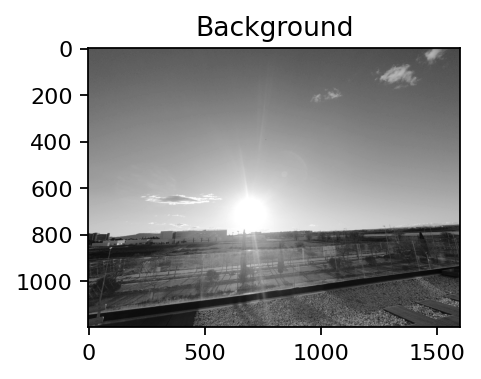

In [5]:
path=r'G0090096_1674924462399.jpg'
image = cv2.imread(path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fondo=gray
plt.figure()
plt.imshow(fondo)
plt.title('Background')
plt.show()


Lo que se encuentra comentado, no se está utilizando, es un método para fusionar una imagen y un clipart. No se opta por este método por dificultades varias, pero se deja comentado porque es interesante y podría ser útil en un futuro

In [6]:
#plane = plt.imread(r'plane.png')
#mascara=plane[:,:,3]
#gray=(cv2.cvtColor(plane, cv2.COLOR_BGR2GRAY))*plane[:,:,3]
#new_sampling = gray[::50,::50]
#imagebox = OffsetImage(plane, zoom=0.08, zorder=1)

#img_gray = cv2.cvtColor(plane, cv2.COLOR_BGR2GRAY)
#plt.figure()
#plt.imshow(plane[:,:,3]*img_gray)
#fig, ax = plt.subplots()

#ab = AnnotationBbox(imagebox, (0, 0), frameon=False)
#cbar_ax = fig.add_axes([0.7, .42, 0.1, 0.1])
#cbar_ax.add_artist(ab)
#cbar_ax.axis('off')

#ax.imshow(fondo)

#plt.figure()
#plt.imshow(plane)


El clipart se basa en 4 matrices en vez de 3, y la cuarta es simplemente una máscara. Con la máscara pones que cuando haya un cero simplemente coges dato del fondo. Esto no está del todo bien, pues en el subsampleo, se coge un 0 para hacer la integración con píxeles cercanos, sin emabrgo, podemos considerar que no está tan mal pues el avión es bastante más brillante que el fondo.

(1200, 1600)


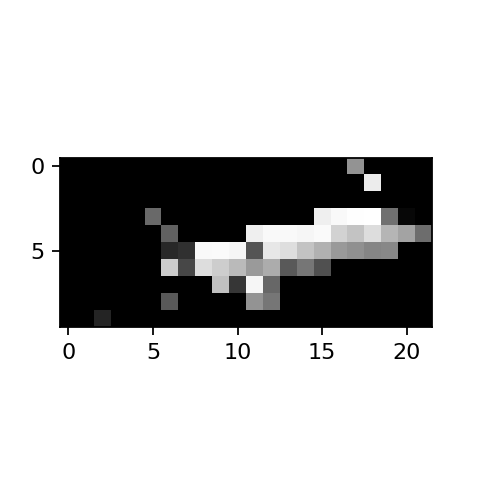

In [30]:
plane = plt.imread(r'plane.png')
mascara=plane[:,:,3]
gray=(cv2.cvtColor(plane, cv2.COLOR_BGR2GRAY))*mascara
new_sampling = (gray[::50,::50])*256
new_mascara = mascara[::100,::100]
print(np.shape(fondo))
plt.figure()
plt.imshow(new_sampling)


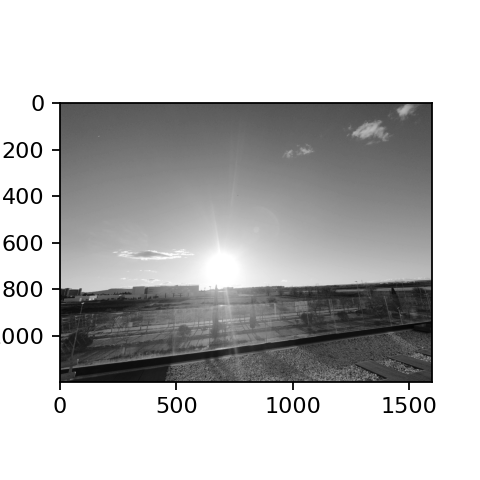

In [28]:
imagen=fondo

a=0
for i in np.arange(0,5):
    for ii in np.arange(0,11):
        if (new_sampling[i,ii]==0):
            new_sampling[i,ii]=fondo[140+i,160+ii]

imagen[140:140+i+1,160:160+ii+1]=(new_sampling)
plt.figure()
plt.imshow(imagen)

Necesitamos cropear la imagen porque no nos da la memoria:

In [9]:
imagen=imagen[100:200,50:600]

# Variograma 1D sobre imagen sintética

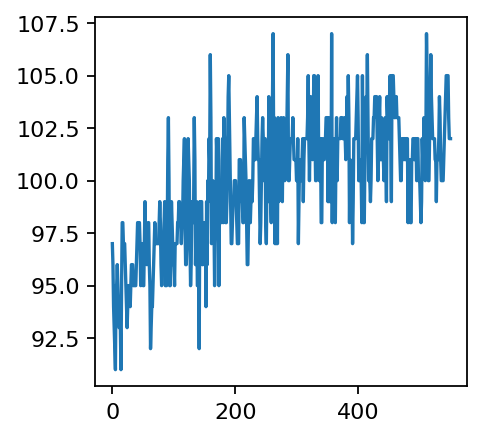

In [10]:
z=imagen[1,:]
x= np.linspace(0, len(z), len(z))

plt.plot(x,z)

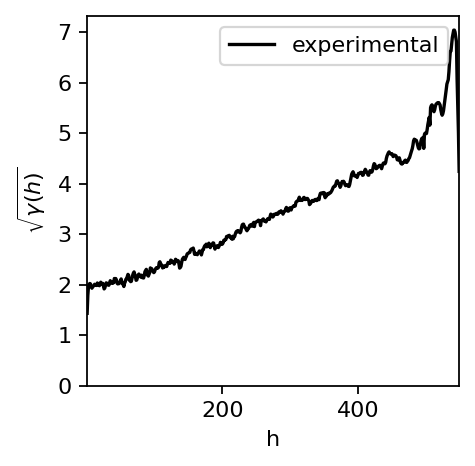

In [11]:
var_exp=experimental(x,z)
i_points = np.arange(0, 700)
var_exp.compute(i_points)
var_exp.draw()

In [12]:
#TODO
fitting1 = fitting(type='gauss', var_exp=var_exp,                 
                   min_bound=np.array([1, 0, 0]),
                   max_bound=np.array([2, 50, 400]))

cost, var_final, optimizer = fitting1.execute()

2023-06-15 11:09:52,513 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=3.85
2023-06-15 11:09:53,748 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.852869303828656, best pos: [  1.5071  28.2009 399.9397]


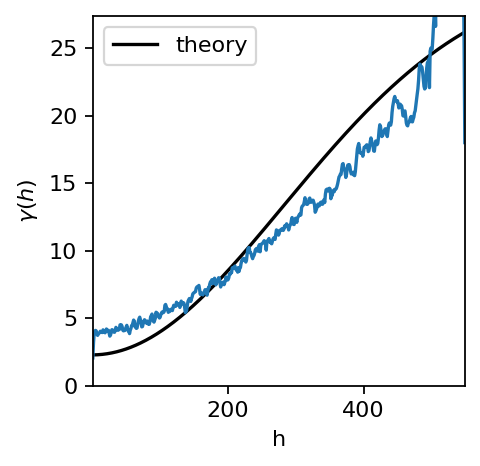

[  1.5071  28.2009 399.9397]


In [13]:
fitting1.draw_fitting('normal')
print(fitting1.param_final)
var_theo = theoretical(h=i_points)
var_theo.gauss(*fitting1.param_final)

# Kriging Standard 2D Imagen

Una vez tenemos realizado el variograma, procedemos a hacer el kriging para detectar posibles amenazas. Ese es el primer punto.

Disclaimer: Se toma el variograma como radial, es decir que tomamos el mismo para todas las filas y columnas. Esto tiene un sc bueno pero la longitud de correlación no lo es.

Definición de parámetros

In [14]:
num_y,num_x=np.shape(imagen)
num_sensors=num_x*num_y

sensors = np.zeros((num_sensors, 4), dtype=float) 

x = np.arange(num_x)
y = np.arange(num_y)

X,Y = np.meshgrid(x,y)
x1= X.flatten()
y1= Y.flatten()
z= imagen.flatten()

sensors[:, 0] = x1
sensors[:, 1] = y1
sensors[:, 2] = z
sensors[:, 3] = 0.5*np.zeros_like(x1) #ruido perteneciente a la incertidumbre de niveles de grises

sensors[:, 2] = sensors[:, 2] + sensors[:, 3] * np.random.randn(num_sensors)
print(print(np.shape(x)))

(550,)
None


In [15]:
#num_sampling = 60**2
#num_x = num_y = int(np.sqrt(num_sampling))
x_sampling = x
y_sampling = y


X_sampling, Y_sampling = np.meshgrid(x_sampling,y_sampling)
sampling2D = (x_sampling, y_sampling)
Sampling2D = (X_sampling, Y_sampling)
krig1 = kriging2D(sensors=sensors, variogram=var_theo, sampling=sampling2D)


In [40]:
print(np.shape(x_sampling))

(60,)


60 60


<Figure size 480x480 with 0 Axes>

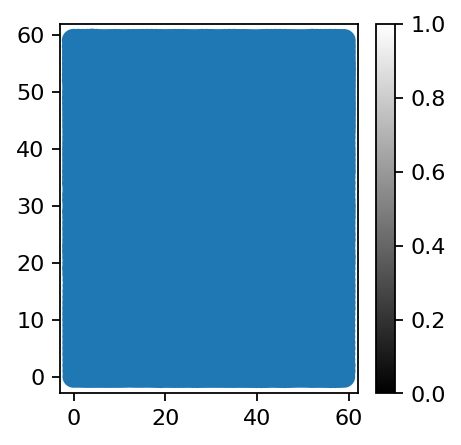

In [41]:
krig1.standard()
plt.figure()
krig1.draw(kind='data')

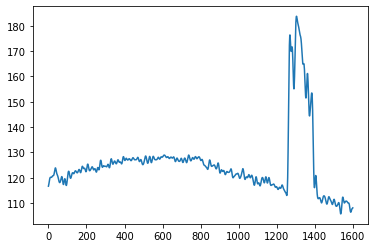

In [ ]:
plt.figure()
plt.plot(krig1.estimation)

# Convolution Kriging 2D

In [16]:
krig2 = Convolution_2D(sensors=sensors,
                       variogram=var_theo,
                       sampling=sampling2D)

100 100


MemoryError: Unable to allocate 22.5 GiB for an array with shape (55000, 55000) and data type float64

In [17]:
krig2.draw('kriging', cmap='gray', circles=False)

NameError: name 'krig2' is not defined

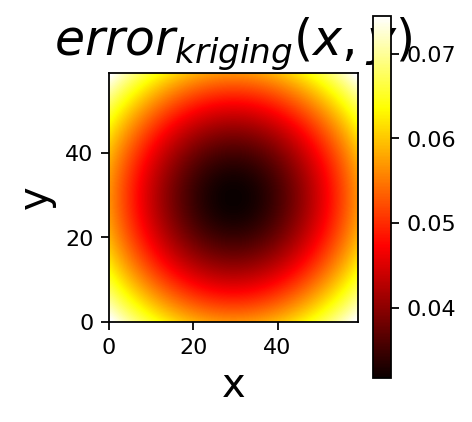

In [77]:
krig2.draw('error_kriging', circles=False)

In [78]:
krig2.center_lambdas()
krig2.compute_DM()
krig2.normalize_DM()
krig2.compute_NEQ()


c:\Program Files\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Bitbucket\phyton_kriging\phyton_kriging\convolution_2D.py:173: RuntimeWarning: Mean of empty slice
  Lambda = np.nanmean(lambdas_centered, axis=2)
C:\Bitbucket\phyton_kriging\phyton_kriging\convolution_2D.py:179: RuntimeWarning: Mean of empty slice
  Lambda = np.nanmean(lambdas_centered, axis=2)


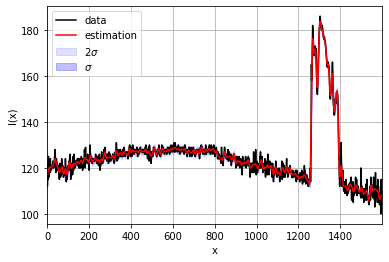

In [53]:
plt.figure()
krig1.draw('kriging')

# Super resolución de la imagen

In [54]:
num_y,num_x=np.shape(gray)
num_sensors=num_x*num_y

sensors = np.zeros((num_sensors, 4), dtype=float) #Cambiar aquí a 4 si hay ruido

x = np.linspace(0, num_x, num_x)
y = np.linspace(0, num_y, num_y)

X,Y = np.meshgrid(x,y)
x= X.flatten()
y= Y.flatten()
z= gray.flatten()

sensors[:, 0] = x
sensors[:, 1] = y
sensors[:, 2] = z
sensors[:, 3] = 0.5*np.zeros_like(x) # ruido perteneciente a la incertidumbre de niveles de grises

sensors[:, 2] = sensors[:, 2] + sensors[:, 3] * np.random.randn(num_sensors)


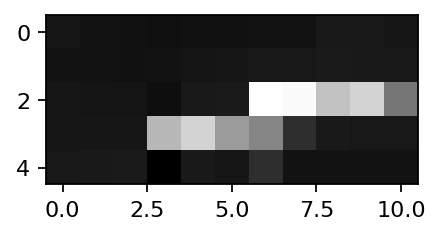

In [23]:
plt.figure()
plt.imshow(new_sampling)
num_y,num_x=np.shape(new_sampling)
num_sensors=num_x*num_y

sensors = np.zeros((num_sensors, 4), dtype=float) 

x = np.arange(num_x)
y = np.arange(num_y)

X,Y = np.meshgrid(x,y)
x1= X.flatten()
y1= Y.flatten()
z= new_sampling.flatten()

sensors[:, 0] = x1
sensors[:, 1] = y1
sensors[:, 2] = z
sensors[:, 3] = 0.5*np.zeros_like(x1) #ruido perteneciente a la incertidumbre de niveles de grises

sensors[:, 2] = sensors[:, 2] + sensors[:, 3] * np.random.randn(num_sensors)

x_sampling = x
y_sampling = y


X_sampling, Y_sampling = np.meshgrid(x_sampling,y_sampling)
sampling2D = (x_sampling, y_sampling)
Sampling2D = (X_sampling, Y_sampling)
krig1 = kriging2D(sensors=sensors, variogram=var_theo, sampling=sampling2D)



In [21]:
var_theo = theoretical(h=i_points)
var_theo.gauss(sc=1, A=28, lc=2)
krig2 = Convolution_2D(sensors=sensors,
                       variogram=var_theo,
                       sampling=sampling2D)

100 100


MemoryError: Unable to allocate 22.5 GiB for an array with shape (55000, 55000) and data type float64

In [ ]:
new_sampling = plane[100::100,::100]
plt.figure()
plt.imshow(new_sampling)


ValueError: slice step cannot be zero